In [ ]:
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scales)
library(DropletUtils)
library(reticulate)
library(repr)
#library(DoubletFinder)
library(future)
library(RColorBrewer)
library(edgeR)
library(limma)
library(GO.db)
library(org.Hs.eg.db)
#library(PCAtools)
options(future.globals.maxSize = 100000 * 1024^2)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 1,]$genes)
bulk_data = read.csv("/home/robotmessenger810/data/buckets/single_cell_bucket_3_4_21/IWT_RNA_seq/scRNA_flowers/outputs/bulk_edger_10_16_20.csv")


In [ ]:
#IWT FILTERING
wt_1_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_26_combined.rds")
wt_2_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_67.rds")
YFP_1_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_101.rds")
YFP_2_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_103.rds")

In [ ]:
# THIS IS THE PREPROCESSING TO GET TO THE INTEGRATED SEURAT OBJECT. JUST UNCOMMENT ENTIRE CELL.
#IWT FILTERING
mut_1_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_27_combined.rds")
mut_2_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_68.rds")
KE_1_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_102.rds")
KE_2_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_104.rds")

#set experimental condition
mut_1_seu@meta.data$condition = "mut_unsorted"
mut_2_seu@meta.data$condition = "mut_unsorted"
KE_1_seu@meta.data$condition = "mut_sorted"
KE_2_seu@meta.data$condition = "mut_sorted"

#set batch
mut_1_seu@meta.data$batch  = "1"
mut_2_seu@meta.data$batch  = "2"
KE_1_seu@meta.data$batch = "3"
KE_2_seu@meta.data$batch = "3"

In [ ]:
counts3 <- as.matrix(GetAssayData(subset(mut_1_seu), slot = "counts"))
counts4 <- as.matrix(GetAssayData(subset(mut_2_seu), slot = "counts"))
counts7 <- as.matrix(GetAssayData(subset(KE_1_seu), slot = "counts"))
counts8 <- as.matrix(GetAssayData(subset(KE_2_seu), slot = "counts"))

In [ ]:
#meam # UMIs/cell
mean(Matrix::colSums(counts3 > 0))
mean(Matrix::colSums(counts4 > 0))
mean(Matrix::colSums(counts7 > 0))
mean(Matrix::colSums(counts8 > 0))

In [ ]:
#mut
mut_1_seu = SCTransform(mut_1_seu)
mut_2_seu = SCTransform(mut_2_seu)
KE_1_seu = SCTransform(KE_1_seu)
KE_2_seu = SCTransform(KE_2_seu)

seu_intd_mut = seu_integrate(mut_2_seu, mut_1_seu, KE_1_seu, KE_2_seu, filename = "1_13_22_mut_sc_68first", nfeatures = 3000)

In [2]:
seu_intd_mut = readRDS(file = "../data/intd_seu_objects/1_13_22_mut_sc_68first.rds")

In [ ]:
#1.25 resolution has lowest HAE/HSL2 entropy
df = specificity_resolution(seu_intd_mut, c("AT4G28490", "AT5G65710"), c(.25, .5, .75, 1, 1.25, 1.5, 1.75, 2))#, 2.25, 2.5, 2.75, 3)))
#saveRDS(df, file = paste("../data/specificity_resolution/", "WT_specificity_resolution_1_18_22", ".rds", sep=""))

In [ ]:
resolution = 1.25
set.seed(42)
DefaultAssay(seu_intd_mut) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
#all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
seu_intd_mut <- RunPCA(seu_intd_mut, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_mut <- FindNeighbors(seu_intd_mut, dims = 1:20, verbose = FALSE)
seu_intd_mut <- FindClusters(seu_intd_mut, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_mut <- RunUMAP(seu_intd_mut, reduction = "pca", dims = 1:20, verbose = FALSE)

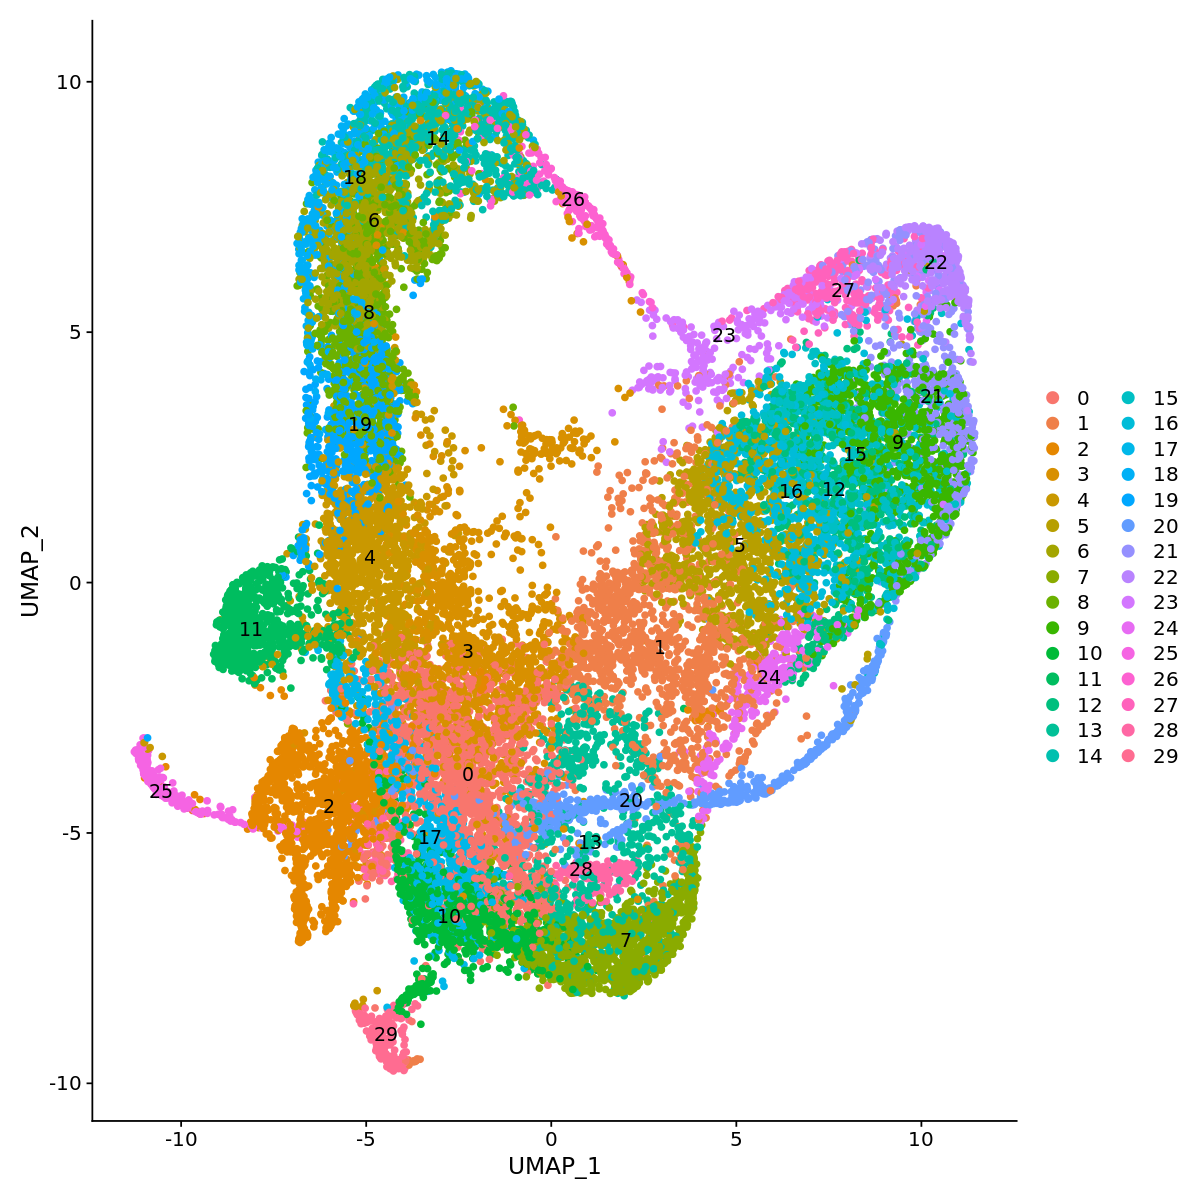

In [9]:
options(repr.plot.width= 10, repr.plot.height=10)
DimPlot(seu_intd_mut, reduction = "umap", label = TRUE, pt.size = 1.5)

In [10]:
saveRDS(seu_intd_mut, file = "../data/seurat_objects/seurat_mut_intd_2_17_22.rds")

In [3]:
#takes a list of Seurat objects with SCT transform run
seu_integrate <- function(..., filename, nfeatures){
    seu.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    ref.genes = rownames(seu.list[[1]]@assays$RNA)
    assay_list <- rep("SCT", length(seu.list))
# loop
#    for (i in 1:length(seu.list)) {
#         seu.list[[i]]@assays$spliced_RNA <- NULL
#         seu.list[[i]]@assays$spliced_SCT <- NULL
#         seu.list[[i]]@assays$unspliced_RNA <- NULL
#         seu.list[[i]]@assays$unspliced_SCT <- NULL
        

    # integration
    rc.features <- SelectIntegrationFeatures(object.list = seu.list, nfeatures = nfeatures)
    rc.features <- rc.features[(!c(grepl("ATMG",rc.features) | grepl("ATCG",rc.features) | rc.features%in%proto_list))]
    
    seu.list <- PrepSCTIntegration(object.list = seu.list, anchor.features = rc.features, verbose = TRUE, assay = assay_list)
    seu.list <- lapply(X = seu.list, FUN = RunPCA, verbose = FALSE, features = rc.features)
    rc.anchors <- FindIntegrationAnchors(object.list = seu.list, normalization.method = "SCT", anchor.features = rc.features, verbose = TRUE, reference=1, reduction = "rpca")
    
    to_integrate <- Reduce(intersect, lapply(rc.anchors@object.list, rownames))
    # integrate data and keep full geneset
       
    rc.integrated <- IntegrateData(anchorset = rc.anchors,  features.to.integrate = to_integrate, normalization.method = "SCT", verbose = TRUE)
    rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
#    }
}


specificity_resolution <- function(seu_obj1, gois, resolutions) { #..., filename, nfeatures){
    total_sum_df = data.frame(matrix(ncol = 6)) #cols = resolution, cluster, goi count, total count, num cells, cross-entropy (?)
    count = 0

    for (r in resolutions) {
        set.seed(42)
        seu_obj = seu_obj1
        DefaultAssay(seu_obj) <- "integrated"
        options(repr.plot.width=12, repr.plot.height=12)
        seu_obj <- RunPCA(seu_obj, npcs = 100, verbose = FALSE, approx = FALSE)
        seu_obj <- FindNeighbors(seu_obj, dims = 1:20, verbose = FALSE)
        seu_obj <- FindClusters(seu_obj, resolution = r, algorithm = 3, verbose = FALSE)
        seu_obj <- RunUMAP(seu_obj, reduction = "pca", dims = 1:20, verbose = FALSE)

        clusters = unique(Idents(seu_obj))
        seu_obj@active.assay = "SCT" #"SCT"
        count = 0
        partial_sum_df = data.frame(matrix(ncol = 6))
        for (c in clusters) {
            count = count + 1
            AZ_cells = (as.matrix(GetAssayData(subset(seu_obj, slot = "counts")[, WhichCells(seu_obj, ident = c)])))
            goi_sum = sum(AZ_cells[gois,])
            total_sum = sum(AZ_cells)

            partial_sum_df[count,1] = r
            partial_sum_df[count,2] = c
            partial_sum_df[count,3] = goi_sum
            partial_sum_df[count,4] = total_sum
            partial_sum_df[count,5] = dim(AZ_cells)[2]

        }

        for (c in clusters) {
            others = partial_sum_df[partial_sum_df[,2] != c,]
            cluster = partial_sum_df[partial_sum_df[,2] == c,]
            #partial_sum_df[which(partial_sum_df[,2]==c),6] = (sum(cluster[,3]!=0)/dim(cluster)[1])/(sum(others[,3]!=0)/dim(others[1]))
            partial_sum_df[which(partial_sum_df[,2]==c),6] = (sum(cluster[,3])/sum(cluster[,4]))/(sum(others[,3])/sum(others[,4]))
        }
        total_sum_df = rbind(total_sum_df, partial_sum_df)
    }
    return(total_sum_df[-1,])
}